In [1]:
import matplotlib
print(matplotlib.__version__)


import sys

import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml


print(f"DECODE version: {decode.utils.bookkeeping.decode_state()}")

3.7.5


/home/GaoQF/miniconda3/envs/decode_env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DECODE version: 0.10.0


In [2]:
device = 'cuda:7'  # or 'cpu', or you change cuda device index
threads = 4  #  number of threads, useful for CPU heavy computation. Change if you know what you are doing.
worker = 0  # number of workers for data loading. Used a default of 0 for safety. Multiprocessing on windows is sometimes not stable

torch.set_num_threads(threads)  # set num threads

if device != 'cpu':
    if not torch.cuda.is_available():
        raise ValueError("You have selected a non CPU device, but CUDA is not available."
                         "Refer to CPU version or check your installation.")

In [6]:
param_path = '/home/GaoQF/Downloads_original/2025-06-27_11-02-22_amax/param_run.yaml'
model_path = '/home/GaoQF/Downloads_original/2025-06-27_11-02-22_amax/model_0.pt'
frame_path = '/data1/ALLData/GaoQF/STORM/data/mitochondria/STORM_256x256_0647-1-30000.tif' #'/data0/ALLData/SMLM/R2/2color 3w.tif' #'/data0/ALLData/SMLM/R3/2COLOR 3W.tif'

# specify camera parameters of tiffs
meta = {
    'Camera': {
        'baseline': 200.0, #200.0, #398.6,
        'e_per_adu': 5.0,
        'em_gain': 100, #100, #50.0,
        'spur_noise': 0.0018 # 0.0018 #0.0015  # if you don't know, you can set this to 0.
    }
}

In [7]:
param = decode.utils.param_io.load_params(param_path)
model = decode.neuralfitter.models.SigmaMUNet.parse(param)
#model = decode.neuralfitter.models.New_model_5.parse(param)
#model = decode.neuralfitter.models.model1.parse(param)
model = decode.utils.model_io.LoadSaveModel(model,
                                            input_file=model_path,
                                            output_file=None).load_init(device=device)

Model instantiated.
Model SHA-1 hash: a07ac4ce480580dd687b68ad0eb22059e0521915
Loaded pretrained model: /home/GaoQF/Downloads_original/2025-06-27_11-02-22_amax/model_0.pt


In [8]:
param = decode.utils.param_io.autofill_dict(meta['Camera'], param.to_dict(), mode_missing='include')
param = decode.utils.param_io.RecursiveNamespace(**param)
print(param)

RecursiveNamespace(Camera=RecursiveNamespace(baseline=200, convert2photons=True, e_per_adu=5.0, em_gain=100, px_size=[160.0, 160.0], qe=0.95, read_sigma=58.8, spur_noise=0.0018), CameraPreset=None, Evaluation=RecursiveNamespace(dist_ax=500.0, dist_lat=250.0, dist_vol=None, match_dims=3), Hardware=RecursiveNamespace(device='cuda:4', device_ix=0, device_simulation='cuda:4', num_worker_train=0, torch_multiprocessing_sharing_strategy=None, torch_threads=4, unix_niceness=0), HyperParameter=RecursiveNamespace(arch_param=RecursiveNamespace(activation='ELU', depth=None, depth_bg=None, depth_shared=2, depth_union=2, init_custom=True, initial_features=48, initial_features_bg=None, inter_features=48, norm=None, norm_bg=None, norm_bg_groups=None, norm_groups=None, norm_head=None, norm_head_groups=None, p_dropout=None, pool_mode='StrideConv', recpt_bg=None, skip_gn_level=None, up_mode='upsample', upsample_mode='nearest', use_last_nl=None), architecture='model_1', auto_restart_param=RecursiveNamespa

In [10]:
frames = decode.utils.frames_io.load_tif('/data1/ALLData/GaoQF/STORM/data/Microtube/S4/STORM_256x256_0001-1-30000.tif')
#frames = torch.load('/data1/ALLData/GaoQF/STORM/data/Fig2_simudata/simu_around/model_output_frames_em_6.pt')

camera = decode.simulation.camera.Photon2Camera.parse(param)
camera.device = 'cpu'

In [11]:
model.eval()

SigmaMUNet(
  (unet_shared): UNet2d(
    (encoder): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ELU(alpha=1.0)
      )
    )
    (base): Sequential(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ELU(alpha=1.0)
    )
    (decoder): ModuleList(
      (0): Sequential(
        (0): Conv2d(192, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv2d(96, 96, kernel_size=(3, 

In [18]:
pp_model = decode.neuralfitter.models.PostProcessNet()
pp_model.load_state_dict(torch.load('/home/GaoQF/Downloads_original/2025-08-10_18-16-11_amax/pp_model_0.pt'))
pp_model.eval()

PostProcessNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_block1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (res_block2): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
 

In [19]:
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.frame_processing.Mirror2D(dims=-1),  # WARNING: You might need to comment this line out. see above
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])

In [20]:
outputs= model(frame_proc.forward(frames[6666].unsqueeze(0).unsqueeze(0))) #, _ 
print(outputs.shape)

torch.Size([1, 10, 256, 256])


In [22]:
pp_output = pp_model(outputs[:, 0].unsqueeze(0))
print(pp_output.shape)

torch.Size([1, 2, 256, 256])


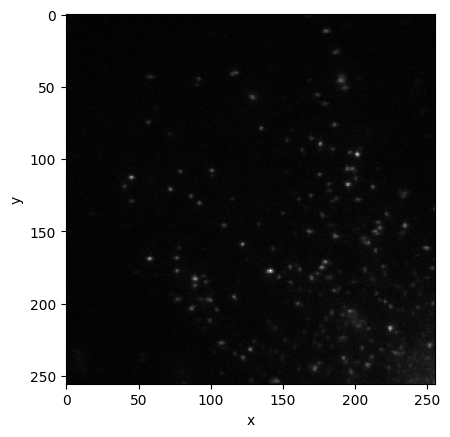

In [24]:


ix = 6666

decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[ix])).plot()



In [23]:
def normalize_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

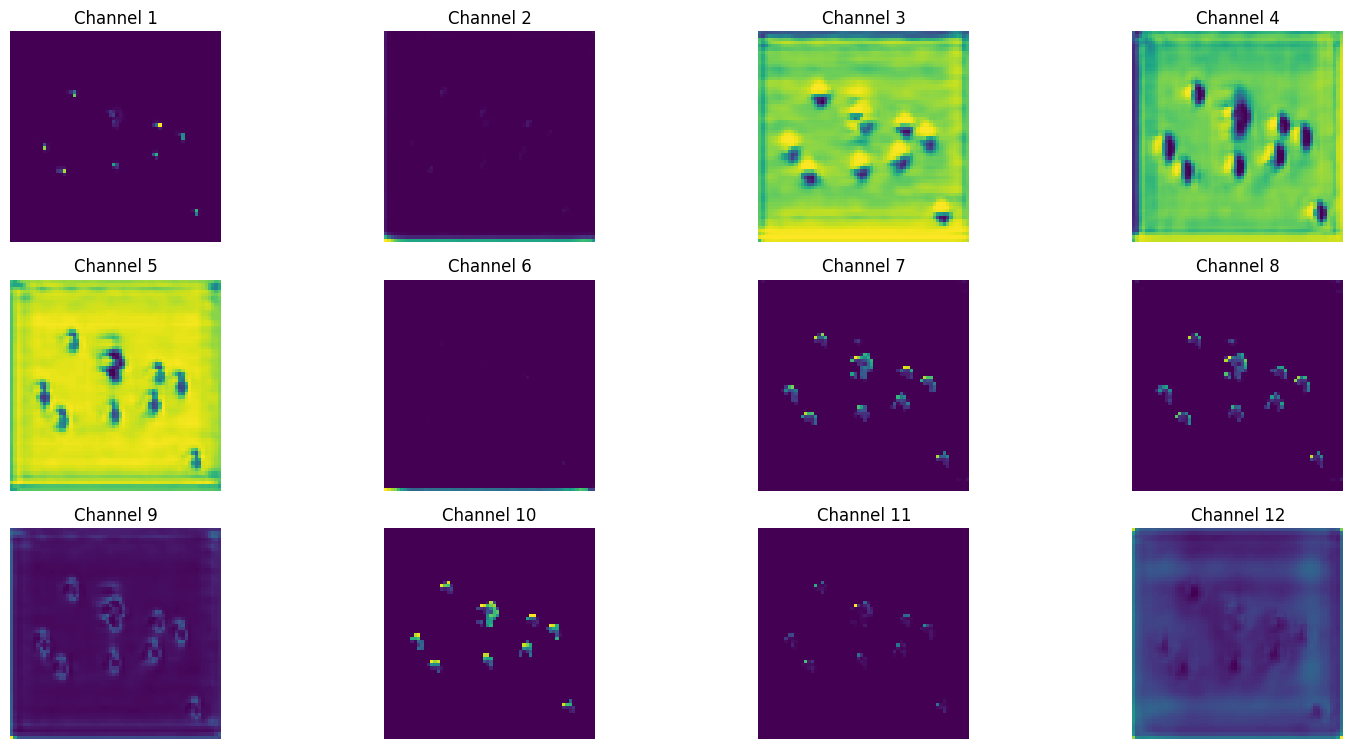

In [24]:
plt.figure(figsize=(16, 8))  # 更宽的图像
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(outputs[:, i].squeeze(0).detach().numpy(), cmap='viridis')
    plt.title(f'Channel {i + 1}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 防止标题重叠
plt.show()